<a href="https://colab.research.google.com/github/jasonpark9001/NLP/blob/main/Using_Various_Embedding_Method_to_Predicting_E_Commerce_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting E-Commerce Product Recommendations from Reviews using various embedding models


![](https://github.com/dipanjanS/feature_engineering_session_dhs18/blob/master/ecommerce_product_ratings_prediction/clothing_banner.jpg?raw=1)

This is a classic NLP project dealing with data from an e-commerce store focusing on women's clothing. Each record in the dataset is a customer review which consists of the review **title, text description and a recommendation 0 or 1** for a product amongst other features.


__Main Objective:__ Leverage the review text attributes and build **deep learning models** to predict the recommendation.

##Phase 1: Data Retrieval and Understanding

##Phase 2: Modeling

##Phase 3: Evaluation, Insights, Recommendations and Report

### Load up basic dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm

     |████████████████████████████████| 106 kB 5.0 MB/s 
     |████████████████████████████████| 287 kB 10.3 MB/s 


### Load and View the Dataset

The data is available at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews 


In [3]:
df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


•	Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.

•	Age: Positive Integer variable of the reviewers age.

•	Title: String variable for the title of the review.

•	Review Text: String variable for the review body.

•	Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

•	Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

•	Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.

•	Division Name: Categorical name of the product high level division.

•	Department Name: Categorical name of the product department name.

•	Class Name: Categorical name of the product class name.


### Basic Data Processing

- Merge all review text attributes (title, text description) into one attribute
- Subset out columns of interest

In [4]:
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]


In [5]:
df.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws I had such high hopes ...,0
3,"My favorite buy! I love, love, love this jumps...",1
4,Flattering shirt This shirt is very flattering...,1


### Remove all records with no review text

### Remove records with no reviews

In [6]:
df_null_count = sum(df['Review'] == ' ')
df_null_count

0

In [7]:

df = df[df['Review'] != " "]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       23486 non-null  object
 1   Recommended  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 550.5+ KB


### There is some imbalance in the data based on product recommendations

In [8]:
df['Recommended'].value_counts()

1    19314
0     4172
Name: Recommended, dtype: int64

### Some Exploratory Data Analysis


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

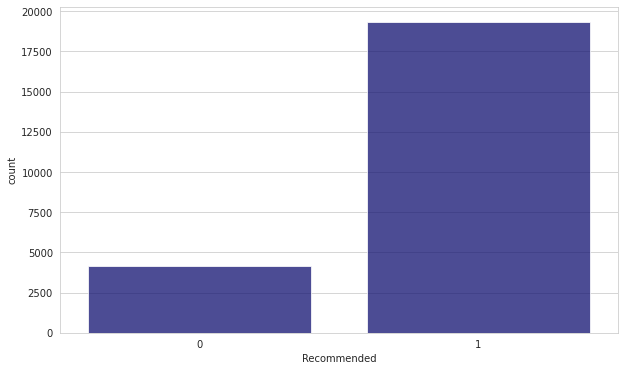

In [10]:
plt.figure(figsize = (10, 6))
sns.countplot(x='Recommended', data= df, color = 'navy', alpha = 0.75)

## Build train and test datasets

In [11]:
df_drop_target = df.drop(columns= ['Recommended'])

In [12]:
df_drop_target.head()

,Review
0,Absolutely wonderful - silky and sexy and comf...
1,Love this dress! it's sooo pretty. i happene...
2,Some major design flaws I had such high hopes ...
3,"My favorite buy! I love, love, love this jumps..."
4,Flattering shirt This shirt is very flattering...


###  Prepare train-test split with ``Recommended`` column as the target variable.



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_drop_target, df['Recommended'], test_size = 0.3, random_state= 42)
X_train.shape, X_test.shape

((16440, 1), (7046, 1))

In [14]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({0: 2914, 1: 13526}), Counter({0: 1258, 1: 5788}))

In [15]:
X_train.head(10)

,Review
20156,"So cute, runs large!!! Love the material, pock..."
10191,Swiss milkmaid This dress is very good quality...
22206,Awesome fit The dress has an awesome fit and t...
19425,Love the jade green I love the greenish option...
4625,Jumpsuit revelations If you haven't yet joined...
11983,Surprisingly comfy for a button down I am a 10...
222,This tunic trumped any other i have seen this ...
3545,Don't pass me by.... Beautiful. did not look l...
16799,From a white shirt collector! I love white shi...
12238,Larkhill swing part deaux Les fauves is anothe...


In [16]:
y_train[:10]

20156    1
10191    1
22206    1
19425    1
4625     1
11983    1
222      1
3545     1
16799    1
12238    1
Name: Recommended, dtype: int64

## Text Pre-processing and Wrangling

We do minimal text pre-processing here given we will be building deep learning models.

In [17]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs


In [18]:
X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

100%|██████████| 7046/7046 [00:00<00:00, 12026.33it/s]


In [19]:
X_train.head(5)

,Review,Clean Review
20156,"So cute, runs large!!! Love the material, pock...",so cute runs large love the material pockets l...
10191,Swiss milkmaid This dress is very good quality...,swiss milkmaid this dress is very good quality...
22206,Awesome fit The dress has an awesome fit and t...,awesome fit the dress has an awesome fit and t...
19425,Love the jade green I love the greenish option...,love the jade green i love the greenish option...
4625,Jumpsuit revelations If you haven't yet joined...,jumpsuit revelations if you have not yet joine...


In [20]:
norm_train_review =X_train['Clean Review'] 
norm_test_review=X_test['Clean Review']


## Experiment 1: Train Classfier with CNN + FastText Embeddings & Evaluate Performance on Test Data
FastText Embedding file path: 
https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

Slightly Smaller file:
https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip



### 1_a. Preprocessing
Trainsforming each review into a sequence to make it prepared test data for the deep learnign model. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf


In [22]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)


In [23]:
#fit the tokenizer on the documents
t = Tokenizer(oov_token ='<UNK>')
t.fit_on_texts(norm_train_review)
t.word_index['<PAD>']=0


###Transfrom the train/test set to sequences using the tokenizer

In [24]:

train_sequences = t.texts_to_sequences(norm_train_review)
test_sequences = t.texts_to_sequences(norm_test_review)


In [25]:
print("Vocab Size: {}".format(len(t.word_index)))
print("Documents Size: {}".format(t.document_count))



Vocab Size: 12149
Documents Size: 16440


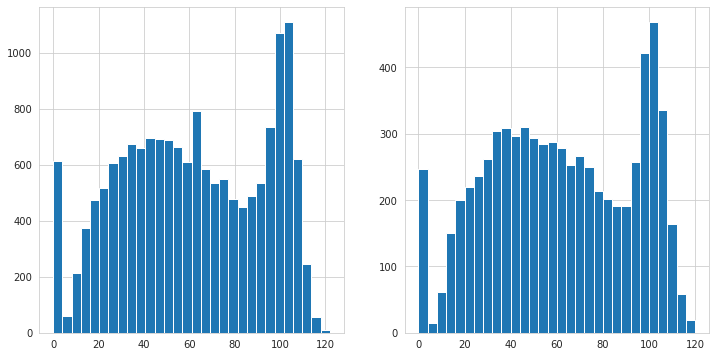

In [26]:
#Take a look at the length of Vocab size of documents
%matplotlib inline
train_lens = [len(s) for s  in train_sequences]
test_lens = [len(s) for s  in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens, bins=30)
h2 =ax[1].hist(test_lens , bins=30)

In [27]:
#Based on the length of each documents' size of vocab we determine the Max sequence length of the sequences.
MAX_SEQ_LEN = 100
X_train_prep = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN)
X_test_prep = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN)


In [28]:
X_train_prep.shape, X_test_prep.shape


((16440, 100), (7046, 100))

In [29]:
y_train.shape, y_test.shape

((16440,), (7046,))

### 1.b Build a classifier using FastText Embeddings

In [30]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-04-13 04:06:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  46.9MB/s    in 16s     

2022-04-13 04:06:44 (41.9 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [31]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [38]:
Vocab_size = len(t.word_index)
Embed_size = 300
Epochs = 100
Batch_size = 128
word2idx = t.word_index
Fast_text_init_embed_file = "./wiki-news-300d-1M.vec"


In [39]:
#create a function which load pretrained embedding

def Load_pretrn_emb(word_2_idx, max_features, embedding_size, emb_file_path):
    def get_coef(word, *arr):
        return word, np.asarray(arr, dtype = 'float32')
    embed_index = dict(get_coef(*row.split(' ')) for row in open(emb_file_path, encoding ='utf8', errors='ignore') if len(row)>100)

    all_emb = np.stack(embed_index.values())
    emb_mean, emb_std = all_emb.mean(), all_emb.std() 
    emb_size= all_emb.shape[1]

    nb_words = min(max_features, len(word_2_idx))
    emb_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    for word, idx in word_2_idx.items():
        if idx >= max_features:
           continue
        emb_vector = embed_index.get(word)
        if emb_vector is not None:
           emb_matrix[idx] = emb_vector
    return emb_matrix



In [40]:
ft_embeddings = Load_pretrn_emb(word_2_idx = word2idx, 
                                max_features = Vocab_size, 
                                embedding_size = Embed_size, 
                                emb_file_path = Fast_text_init_embed_file)
ft_embeddings.shape


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(12149, 300)

###1.c Build model Architecture
Using ``tensorflow.keras`` high level API for buiding the DNN model. We set weights parameter from FastText embedding instead of randome weights in the initial layer. We also use ``trainable`` parameter as ``True`` to learn/improve the pretrained weights. 

In [42]:
model_ft = tf.keras.models.Sequential()

model_ft.add(tf.keras.layers.Embedding(Vocab_size, Embed_size, weights = [ft_embeddings], trainable = True, input_length= MAX_SEQ_LEN))
model_ft.add(tf.keras.layers.Conv1D(filters =256, kernel_size=4, padding = 'same', activation= 'relu'))
model_ft.add(tf.keras.layers.MaxPool1D(pool_size=2))
model_ft.add(tf.keras.layers.Conv1D(filters =128, kernel_size=4, padding = 'same', activation= 'relu'))
model_ft.add(tf.keras.layers.MaxPool1D(pool_size=2))
model_ft.add(tf.keras.layers.Conv1D(filters =64, kernel_size=4, padding = 'same', activation= 'relu'))
model_ft.add(tf.keras.layers.MaxPool1D(pool_size=2))

model_ft.add(tf.keras.layers.Flatten())

model_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_ft.add(tf.keras.layers.Dropout(0.25))
model_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_ft.add(tf.keras.layers.Dropout(0.25))
model_ft.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ft.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3644700   
                                                                 
 conv1d (Conv1D)             (None, 100, 256)          307456    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 64)            3

### 1.d Train and Validate Model

In [ ]:
# Fit the model
model_ft.fit(X_train_prep, y_train, 
          validation_split=0.02,
          epochs=Epochs, 
          batch_size=Batch_size, 
          shuffle=True,
          verbose=1)

In [45]:
prediction_probs = model_ft.predict(X_test_prep, verbose = 1).ravel()
prediction = [1 if prob > 0.5 else 0 for prob in prediction_probs]
prediction[:10]

221/221 [==============================] - 1s 3ms/step


[1, 1, 1, 0, 1, 1, 1, 1, 1, 1]

In [46]:
print( classification_report(y_test, prediction))
lable = [['negative', 'positive']]
pd.DataFrame(confusion_matrix(y_test, prediction), index=lable, columns=lable)

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1258
           1       0.93      0.95      0.94      5788

    accuracy                           0.91      7046
   macro avg       0.85      0.82      0.84      7046
weighted avg       0.90      0.91      0.91      7046



,negative,positive
negative,868,390
positive,265,5523


# Experiment 2: Train Classfier with LSTM + FastText Embeddings & Evaluate Performance on Test Data



###2.a Build model Architecture

In [64]:

LSTM_DIM=128

model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(Vocab_size, Embed_size, weights = [ft_embeddings], trainable = True, input_length= MAX_SEQ_LEN))

model_LSTM.add(tf.keras.layers.SpatialDropout1D(0.1))

model_LSTM.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_LSTM.add(tf.keras.layers.Dense(256, activation='relu'))

model_LSTM.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_LSTM.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          3644700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,897,629
Trainable params: 3,897,629
Non-trainable params: 0
____________________________________________

### 2.b Train the model

In [65]:
batch_size = 128
EPOCHS = 10

#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

model_LSTM.fit(X_train_prep, y_train, epochs=EPOCHS, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
116/116 [==============================] - 5s 19ms/step - loss: 0.3689 - accuracy: 0.8396 - val_loss: 0.2596 - val_accuracy: 0.8814
Epoch 2/10
116/116 [==============================] - 2s 18ms/step - loss: 0.2126 - accuracy: 0.9128 - val_loss: 0.2302 - val_accuracy: 0.9015
Epoch 3/10
116/116 [==============================] - 2s 18ms/step - loss: 0.1670 - accuracy: 0.9349 - val_loss: 0.2348 - val_accuracy: 0.9015
Epoch 4/10
116/116 [==============================] - 2s 17ms/step - loss: 0.1335 - accuracy: 0.9510 - val_loss: 0.2504 - val_accuracy: 0.9015
Epoch 5/10
116/116 [==============================] - 2s 16ms/step - loss: 0.1082 - accuracy: 0.9589 - val_loss: 0.2773 - val_accuracy: 0.8923
Epoch 6/10
116/116 [==============================] - 2s 18ms/step - loss: 0.0833 - accuracy: 0.9691 - val_loss: 0.3191 - val_accuracy: 0.8966
Epoch 7/10
116/116 [==============================] - 2s 15ms/step - loss: 0.0650 - accuracy: 0.9760 - val_loss: 0.3823 - val_accuracy: 0.9009

###2.c Evaluate LSTM Model

In [66]:
prediction_LSTM = model_LSTM.predict(X_test_prep, verbose = 1).ravel()
predict_LSTM = [1 if prod >0.5 else 0 for prod in prediction_LSTM]
predict_LSTM[:10]

221/221 [==============================] - 2s 6ms/step


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [67]:
print(classification_report(y_test, predict_LSTM))
lable = [['negative', 'positive']]
pd.DataFrame(confusion_matrix(y_test,predict_LSTM), index = lable, columns = lable)

              precision    recall  f1-score   support

           0       0.77      0.55      0.65      1258
           1       0.91      0.96      0.94      5788

    accuracy                           0.89      7046
   macro avg       0.84      0.76      0.79      7046
weighted avg       0.88      0.89      0.88      7046



,negative,positive
negative,698,560
positive,205,5583


# Experiment 3: Train Classfier with NNLM Universal Embedding Model

__Hint:__ This model should accept the pre-processed text directly (as shown in livecoding)


###3.a Build a classifier using NNLM Universal Embeddings

In [61]:
X_train_NNLM = X_train['Clean Review']
X_test_NNLM = X_test['Clean Review']

In [56]:
X_train_NNLM

20156    so cute runs large love the material pockets l...
10191    swiss milkmaid this dress is very good quality...
22206    awesome fit the dress has an awesome fit and t...
19425    love the jade green i love the greenish option...
4625     jumpsuit revelations if you have not yet joine...
                               ...                        
11964    did not work i saw this very shirt online thou...
21575    royal albert style this dress attracted my att...
5390     size up i have a countless number of maeve dre...
860      perfect this top is great lightweight and flat...
15795    artsy and comfy as other reviewers mentioned t...
Name: Clean Review, Length: 16440, dtype: object

In [58]:
model_NNLM = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model_NNLM, output_shape=[128], input_shape = [],
                           dtype= tf.string, trainable = True)
print(hub_layer(np.array(X_train_NNLM)))

tf.Tensor(
[[ 0.73644507 -0.06525341  0.13410246 ... -0.13080202 -0.11861407
   0.06584998]
 [ 1.3902172  -0.06182861  0.13309427 ... -0.40157598 -0.16939718
  -0.1130283 ]
 [ 0.60588557  0.04202041  0.15838915 ... -0.16682416 -0.0608409
  -0.04502573]
 ...
 [ 0.79559284  0.14656658  0.07661476 ... -0.13173251  0.07757743
  -0.01372074]
 [ 0.73507404  0.02248546  0.3338712  ... -0.1637388  -0.08575101
  -0.11069231]
 [ 1.1576834  -0.03761234  0.17260079 ... -0.21967322 -0.08831155
   0.08235928]], shape=(16440, 128), dtype=float32)


###3.b Build Model Architecture 
Using TF_hub pretrained model

In [59]:
model_NNLM = tf.keras.models.Sequential()

model_NNLM.add(hub_layer)
model_NNLM.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_NNLM.add(tf.keras.layers.Dropout(0.25))


model_NNLM.add(tf.keras.layers.Dense(128, activation = 'relu'))
model_NNLM.add(tf.keras.layers.Dropout(0.25))


model_NNLM.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_NNLM.compile( loss = 'binary_crossentropy', optimizer= 'adam',metrics=['accuracy'])

model_NNLM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,675,841
Trainable params: 124,675,84

###3.c Train and Validation Model


In [60]:
# Fit the model
#es_nnlm = tf.keras.callbacks.EarlyStopping(monitor = 'loss_val',    patience = 3,restore_best_weights = True, verbose= 1)
model_NNLM.fit(X_train_NNLM, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_split = 0.02 )

Epoch 1/10
126/126 [==============================] - 11s 80ms/step - loss: 0.3201 - accuracy: 0.8554 - val_loss: 0.1734 - val_accuracy: 0.9179
Epoch 2/10
126/126 [==============================] - 11s 84ms/step - loss: 0.1936 - accuracy: 0.9225 - val_loss: 0.1762 - val_accuracy: 0.9179
Epoch 3/10
126/126 [==============================] - 10s 76ms/step - loss: 0.1510 - accuracy: 0.9413 - val_loss: 0.1770 - val_accuracy: 0.9179
Epoch 4/10
126/126 [==============================] - 9s 74ms/step - loss: 0.1243 - accuracy: 0.9540 - val_loss: 0.2113 - val_accuracy: 0.9119
Epoch 5/10
126/126 [==============================] - 10s 78ms/step - loss: 0.0976 - accuracy: 0.9638 - val_loss: 0.2670 - val_accuracy: 0.8936
Epoch 6/10
126/126 [==============================] - 9s 74ms/step - loss: 0.0798 - accuracy: 0.9711 - val_loss: 0.3003 - val_accuracy: 0.8936
Epoch 7/10
126/126 [==============================] - 9s 75ms/step - loss: 0.0636 - accuracy: 0.9777 - val_loss: 0.3448 - val_accuracy: 0.

###3.d Model Performance Evaluation on the Test Dataset

In [62]:
predict_prob_NNLM = model_NNLM.predict(np.array(X_test_NNLM), verbose=1).ravel()
predictions_NNLM = [1 if prob >0.5 else 0 for prob in predict_prob_NNLM]
predictions_NNLM[:10]

221/221 [==============================] - 2s 7ms/step


[1, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [63]:
print(classification_report(y_test, predictions_NNLM))
lable = [['negative', 'positive']]
pd.DataFrame(confusion_matrix(y_test,predictions_NNLM), index = lable, columns = lable)

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1258
           1       0.93      0.94      0.93      5788

    accuracy                           0.89      7046
   macro avg       0.82      0.80      0.81      7046
weighted avg       0.89      0.89      0.89      7046



,negative,positive
negative,838,420
positive,347,5441


# Experiment 4: Train Classfier with BERT

##### Note: You might need to restart the notebook environment on colab after installing the below library


### **Question 6**: Build a classifier using BERT Embeddings

In [ ]:
!pip install transformers --ignore-installed

##### Note: Run the below cell to get all the pre-processed data again in case you needed to reload the notebook after the above installation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df = df[df['Review'] != '']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']


### BERT Data preparation
We need to preprocess our data so that it matches the data format BERT was trained on. For this, we'll need to do a couple of things.

- Lowercase our text (if we're using a BERT lowercase model)
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
- Map our words to indexes using a vocab file that BERT provides
- Add special "CLS" and "SEP" tokens (see the readme)
- Append "mask" and "segment" tokens to each input (see the BERT paper)

In [70]:
import transformers

In [78]:
train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']


In [86]:
train_clean_text

20156    so cute runs large love the material pockets l...
10191    swiss milkmaid this dress is very good quality...
22206    awesome fit the dress has an awesome fit and t...
19425    love the jade green i love the greenish option...
4625     jumpsuit revelations if you have not yet joine...
                               ...                        
11964    did not work i saw this very shirt online thou...
21575    royal albert style this dress attracted my att...
5390     size up i have a countless number of maeve dre...
860      perfect this top is great lightweight and flat...
15795    artsy and comfy as other reviewers mentioned t...
Name: Clean Review, Length: 16440, dtype: object

In [75]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # ones for all tokens
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [72]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model_bert = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [96]:
MAX_SEQ_LENGTH = 100

In [97]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_clean_text, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         test_clean_text, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Converting docs to features: 100%|██████████| 7046/7046 [00:10<00:00, 693.95it/s]


Train Features: (16440, 100) (16440, 100) (16440, 100)
Val Features: (7046, 100) (7046, 100) (7046, 100)


In [98]:
train_features_ids

array([[  101,  2061, 10140, ...,     0,     0,     0],
       [  101,  5364,  6501, ...,  2946,  1998,   102],
       [  101, 12476,  4906, ...,     0,     0,     0],
       ...,
       [  101,  2946,  2039, ...,     0,     0,     0],
       [  101,  3819,  2023, ...,     0,     0,     0],
       [  101,  2840,  2100, ...,  2071,  2022,   102]])

In [99]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_clean_text, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 7046/7046 [00:11<00:00, 606.99it/s]


Test Features: (7046, 100) (7046, 100) (7046, 100)


In [100]:
test_features_ids

array([[  101,  2946,  2039, ...,  3621, 12347,   102],
       [  101, 10245,  2392, ...,     0,     0,     0],
       [  101, 23677,  3376, ...,     0,     0,     0],
       ...,
       [  101,  5293,  2033, ...,  6546,  2640,   102],
       [  101,  7163,  2544, ...,  1997,  2026,   102],
       [  101,  3376,  6140, ...,  5808,  2181,   102]])

###4.b Build Model Architecture 


In [101]:


inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_bert = tf.keras.Model(inputs=inputs, outputs=output)

model_bert.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), loss='binary_crossentropy', metrics=['accuracy'])

model_bert.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 100)]        0           []                               
                                                                                                  
 bert_segment_ids (InputLayer)  [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['bert_input_ids[0][0]',         
                                thPoolingAndCrossAt               'bert_input_masks[0][0]', 

###4.c Train and Evaluate your BERT model using `transformers`

In [102]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1)
model_bert.fit([train_features_ids, train_features_masks, train_features_segments], 
               y_train, 
               validation_data=([val_features_ids, val_features_masks, val_features_segments], y_test),
               epochs=3, 
               batch_size=13, 
               callbacks=[es],
               shuffle=True,
               verbose=1)

Epoch 1/3
1265/1265 [==============================] - 481s 368ms/step - loss: 0.2287 - accuracy: 0.9062 - val_loss: 0.1742 - val_accuracy: 0.9269
Epoch 2/3
1265/1265 [==============================] - 437s 345ms/step - loss: 0.1469 - accuracy: 0.9426 - val_loss: 0.1812 - val_accuracy: 0.9236
Epoch 2: early stopping


###4.d Model Performance Evaluation on the Test Dataset

In [103]:
from sklearn.metrics import accuracy_score

In [104]:
predictions_bert = [1 if pr > 0.5 else 0 
                   for pr in model_bert.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions_bert)*100))
print(classification_report(y_test, predictions_bert))
lable = [['negative', 'positive']]
pd.DataFrame(confusion_matrix(y_test,predictions_bert), index = lable, columns = lable)

Accuracy: 92.69%
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1258
           1       0.95      0.96      0.96      5788

    accuracy                           0.93      7046
   macro avg       0.88      0.87      0.87      7046
weighted avg       0.93      0.93      0.93      7046



,negative,positive
negative,979,279
positive,236,5552


# Experiment 5: Train Classfier with DistilBERT


###5.a DistilBERT Tokenizer

In [105]:
tokenizer_dbert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

###5.b DistillBERT Data Preparation

In [106]:
def create_Dbert_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        all_ids.append(ids)
        all_masks.append(masks)
        
    encoded = np.array([all_ids, all_masks])
    
    return encoded

###5.c Build Model Architecture

In [107]:
MAX_SEQ_LENGTH = 100

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model_dbert = tf.keras.Model(inputs=inputs, outputs=output)
model_dbert.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model_dbert.summary()

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['bert_input_ids[0][0]',         
 BertModel)                     ast_hidden_state=(N               'bert_input_masks[0][0]']       
                                one, 100, 768),                                                   
                                 hidden_states=None                                         

###5.d Convert Text to DistillBERT input features

In [108]:
dbert_train_features_ids, dbert_train_features_masks = create_Dbert_features(tokenizer_dbert, train_clean_text, max_seq_length=MAX_SEQ_LENGTH)
dbert_val_features_ids, dbert_val_features_masks = create_Dbert_features(tokenizer_dbert, test_clean_text, max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', dbert_train_features_ids.shape, dbert_train_features_masks.shape)
print('Val Features:', dbert_val_features_ids.shape, dbert_val_features_masks.shape)

Converting docs to features: 100%|██████████| 7046/7046 [00:16<00:00, 418.84it/s]


Train Features: (16440, 100) (16440, 100)
Val Features: (7046, 100) (7046, 100)


In [109]:
dbert_test_features_ids, dbert_test_features_masks = create_Dbert_features(tokenizer_dbert, test_clean_text, max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', dbert_test_features_ids.shape, dbert_test_features_masks.shape)

Converting docs to features: 100%|██████████| 7046/7046 [00:20<00:00, 344.55it/s]


Test Features: (7046, 100) (7046, 100)


###5.e Train and Validate Model

In [110]:
model_dbert.fit([dbert_train_features_ids, dbert_train_features_masks], y_train, 
                validation_data=([dbert_val_features_ids, dbert_val_features_masks], y_test),
                epochs=3, 
                batch_size=20, 
                shuffle=True,
                callbacks=[es],
                verbose=1)

Epoch 1/3
822/822 [==============================] - 205s 239ms/step - loss: 0.2440 - accuracy: 0.8944 - val_loss: 0.1800 - val_accuracy: 0.9258
Epoch 2/3
822/822 [==============================] - 196s 239ms/step - loss: 0.1517 - accuracy: 0.9404 - val_loss: 0.1787 - val_accuracy: 0.9255
Epoch 3/3
822/822 [==============================] - 196s 239ms/step - loss: 0.1033 - accuracy: 0.9630 - val_loss: 0.2184 - val_accuracy: 0.9215
Epoch 3: early stopping


### Model Performance Evaluation on the Test Dataset

In [111]:
predictions_dbert = [1 if pr > 0.5 else 0 
                   for pr in model_dbert.predict([dbert_test_features_ids, dbert_test_features_masks], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions_dbert)*100))
print(classification_report(y_test, predictions_dbert))
lable = [['negative', 'positive']]
pd.DataFrame(confusion_matrix(y_test,predictions_dbert), index = lable, columns = lable)

Accuracy: 92.55%
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1258
           1       0.95      0.96      0.95      5788

    accuracy                           0.93      7046
   macro avg       0.88      0.86      0.87      7046
weighted avg       0.92      0.93      0.92      7046



,negative,positive
negative,967,291
positive,234,5554
